In [1]:
using CartesianGrids

In [2]:
using Plots

In [3]:


# ======  Regular tridiagonal matrices ==============#

# For scalar-valued a, b, c, call the vector-valued form. This ensures
# that we have only one function to write and debug
function thomas(a::Real,b::Real,c::Real,f::Vector{<:Real})
  n = length(f)
  ftype = eltype(f) # this is to ensure that a, b, c elements have same type as f
  return thomas(a*ones(ftype,n-1),
                b*ones(ftype,n),
                c*ones(ftype,n-1),f)
end

function thomas(a::Vector{<:Real},b::Vector{<:Real},c::Vector{<:Real},f::Vector{<:Real})
  # This is the main algorithm for regular circulant matrices

  # We will develop the solution x in place
  x = copy(f)

  M = length(f)

  if b[1] == 0
    error("First pivot is zero")
  end

  # Modify the first row of coefficients
  x[1] /= b[1]

  if M == 1
    # There is only one entry, so we are done!
    return x
  end

  ctmp = copy(c)
  
  ctmp[1] /= b[1]
  tmp1 = ctmp[1]
  tmp2 = x[1]
  for i = 2:M-1
    tmp = b[i] - a[i-1]*tmp1
    tmp1 = ctmp[i]/tmp
    tmp2 = (x[i]-a[i-1]*tmp2)/tmp
    ctmp[i] = tmp1
    x[i] = tmp2
  end
  x[M] = (x[M]-a[M-1]*x[M-1])/(b[M]-a[M-1]*ctmp[M-1])

  # Back substitute
  tmp = x[M]
  for i = M-1:-1:1
    tmp = x[i] - ctmp[i]*tmp
    x[i] = tmp
  end

  return x

end

thomas (generic function with 2 methods)

In [4]:
function trimult(a::Vector{<:Real},b::Vector{<:Real},c::Vector{<:Real},f::Vector{<:Real})
    g = zero(f)
    n = length(f)
    g[1] = b[1]*f[1] + c[1]*f[2]
    for i in 2:n-1
        g[i] = a[i-1]*f[i-1] + b[i]*f[i] + c[i]*f[i+1]
    end
    g[n] = a[n-1]*f[n-1] + b[n]*f[n]
    return g
end

trimult (generic function with 1 method)

$$(I - 0.5 Fo D_x) T^{n+1} = (I + 0.5 Fo D_x) T^{n}$$

In [5]:
function get_Tnp1(Tn)
    Tstar = trimult(ar,br,cr,Tn)
    Tnp1 = thomas(al,bl,cl,Tstar);
    return Tnp1
end

get_Tnp1 (generic function with 1 method)

In [6]:
L = 1;
n = 102;
i = 2:n-1;
dx = L/(n-2);
xg = (i .- 3/2)*dx

κ = 1.0

Fo = 5.0;
dt = Fo*dx^2/κ

0.0005

In [7]:
ar = zeros(n-3)
br = zeros(n-2)
cr = ar

al = zeros(n-3)
bl = zeros(n-2)
cl = al

ar .= 0.5*Fo;
br .= 1-Fo;
br[1] = br[end] = 1-0.5*Fo;

al .= -0.5*Fo;
bl .= 1+Fo;
bl[1] = bl[end] = 1+0.5*Fo;

In [8]:
Sturm-Liouville

LoadError: [91mUndefVarError: Sturm not defined[39m

In [13]:
p = 2;
T0 = cos.(p*π*xg/L);

#T0 = exp.(-(xg .- L/2).^2/(0.1*L)^2)
Texact(t) = exp(-κ*(p*π/L)^2*t)*T0;

$$e^{-\kappa(p\pi/L)^2 t} \cos(p \pi x/L)$$

In [14]:
t = 0.0
Tn = copy(T0);
for i in 1:100
    t += dt;
    Tn .= get_Tnp1(Tn);
end

In [15]:
round(t,digits=3)

0.05

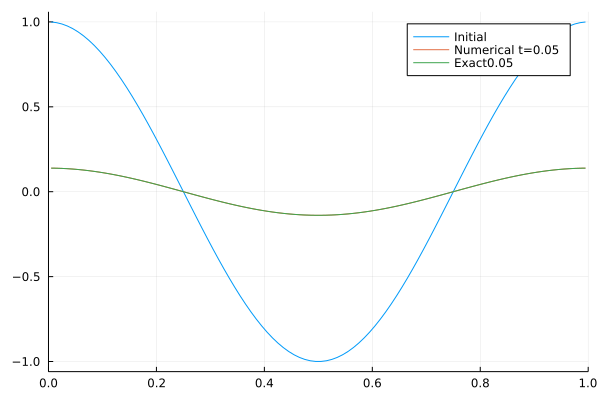

In [16]:
plot(xg,T0,label="Initial",xlims=(0,L))
plot!(xg,Tn,label="Numerical t="*string(round(t,digits=3)))
plot!(xg,Texact(t),label="Exact"*string(round(t,digits=3)))